## Nombre: Miguel Angel Domínguez Mendoza

## Matrícula: 2085384

Importo las librerias necesarias

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

Arquitectura del Modelo VGG16

In [ ]:
from keras.applications.vgg16 import VGG16
# Cargamos el modelo
model = VGG16()
# Sintesis del modelo
model.summary()

553476096/553467096 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Arquitectura del modelo Inception versión 3

In [ ]:
from keras.applications.inception_v3 import InceptionV3
# Carga de modelo
model = InceptionV3()
# summarize the model
model.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

Definimos los diferentes parámetros que necesitamos para la ejecución de los modelos.
Definimos el tamaño de la imagen, la ruta de las imágenes del entrenamiento y la ruta de las imágenes del conjunto de validación y el batch size.
La semilla aleatoria en caso de que queramos repetir el experimiento.

In [ ]:
im_shape = (224,224)

TRAINING_DIR = '/content/drive/MyDrive/Colab Notebooks/Procesamiento_y_Clasificacion_de_Datos/Tarea_7/ds_frutas_am/train'
TEST_DIR = '/content/drive/MyDrive/Colab Notebooks/Procesamiento_y_Clasificacion_de_Datos/Tarea_7/ds_frutas_am/test'

seed = 10

BATCH_SIZE = 16

Realizamos la técnica de aumento de datos para generar más imágenes de manera aletoria utilizando diversos filtros:


1.   Rango de rotación de hasta 20
2.   Cambio de altura y ancho de hasta 20%
3.   Zoom in y zoom out de hasta 20%
4.   Volteo Horizontal
5.   Distorción de uno de los ejes ya sea el horizontal o el vertical de hasta 20%







In [ ]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [ ]:
# Generator para conjunto de entrenamiento
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para conjunto de prueba
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para conjunto de validación
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


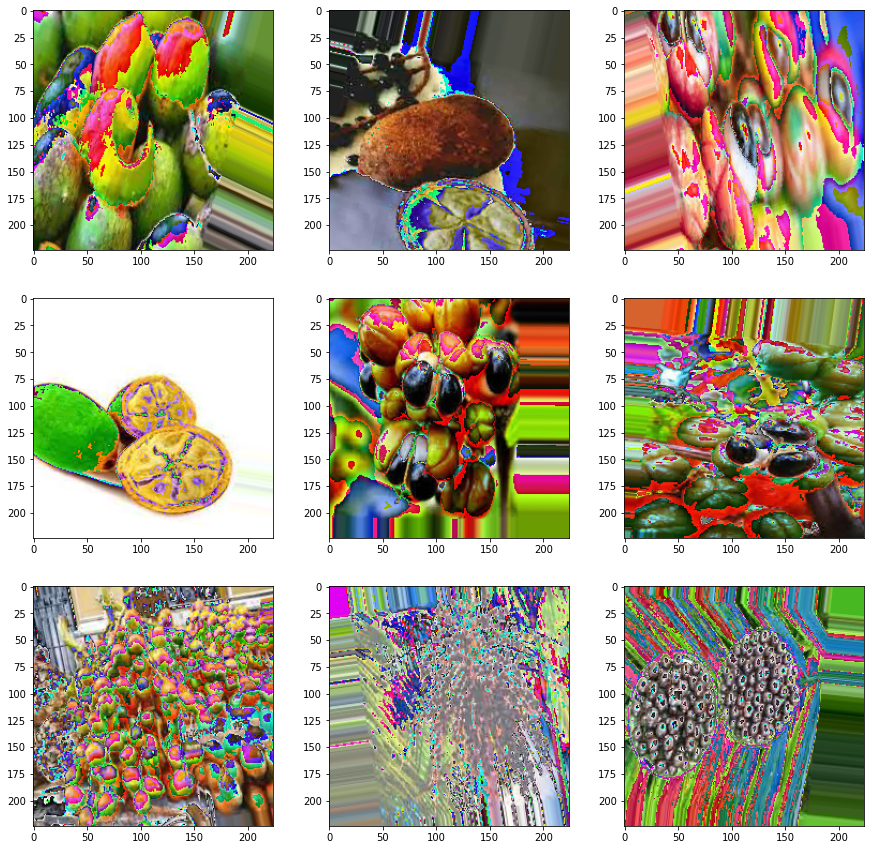

In [ ]:
# Podemos observar un par de ejemplos creados con esta técnica de aumentos de datos
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

## Transfer Learning

### VGG16

Comenzaremos con el modelo VGG16

In [ ]:
from keras.applications.vgg16 import VGG16

Para evitar que tome mucho tiempo el procesamiento de este modelo, no descongelaremos ninguna de las capas

In [ ]:
vgg_model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
  layer.trainable = False
# Make sure you have frozen the correct layers
for i, layer in enumerate(vgg_model.layers):
  print(i, layer.name, layer.trainable)

58900480/58889256 [==============================] - 0s 0us/step
0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
x = vgg_model.output
x = Flatten()(x) # La salida del modelo VGG tenemos que llevarla a una capa de aplanamiento para poder entrar en la parte de fully connection
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Agregamos una capa de dropout para evitar el sobreentranamiento
x = Dense(256, activation='relu')(x)
x = Dense(6, activation='softmax')(x) # Como tenemos una tarea de multiclasifación añadiremos una función de activación soft max de 6 neuronas, una por cada clase
transfer_model = Model(inputs=vgg_model.input, outputs=x)

Definimos la función de pérdida como Entropía cruzada categórica.
Para el optimizador utilizamos un ADAM que partirá de una learning rata muy pequeña.

In [ ]:
learning_rate= 5e-5
transfer_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = transfer_model.fit(train_generator, batch_size = 1, epochs=50, validation_data=validation_generator)

Epoch 1/50
5/5 [==============================] - 51s 10s/step - loss: 2.1039 - accuracy: 0.1667 - val_loss: 1.7044 - val_accuracy: 0.2222
Epoch 2/50
5/5 [==============================] - 49s 10s/step - loss: 1.9168 - accuracy: 0.2361 - val_loss: 1.7288 - val_accuracy: 0.2778
Epoch 3/50
5/5 [==============================] - 46s 9s/step - loss: 1.7017 - accuracy: 0.2917 - val_loss: 1.5796 - val_accuracy: 0.4444
Epoch 4/50
5/5 [==============================] - 46s 9s/step - loss: 1.5214 - accuracy: 0.3889 - val_loss: 1.4346 - val_accuracy: 0.6667
Epoch 5/50
5/5 [==============================] - 46s 9s/step - loss: 1.3366 - accuracy: 0.4444 - val_loss: 1.3437 - val_accuracy: 0.6111
Epoch 6/50
5/5 [==============================] - 46s 9s/step - loss: 1.3631 - accuracy: 0.4306 - val_loss: 1.2864 - val_accuracy: 0.5556
Epoch 7/50
5/5 [==============================] - 46s 9s/step - loss: 1.2463 - accuracy: 0.6111 - val_loss: 1.2281 - val_accuracy: 0.6667
Epoch 8/50
5/5 [================

In [ ]:
import pandas as pd

Graficamos el comportamiento del perfomance que tuvo durante cada época para tanto en la función en la pérdida como en la de asertividad

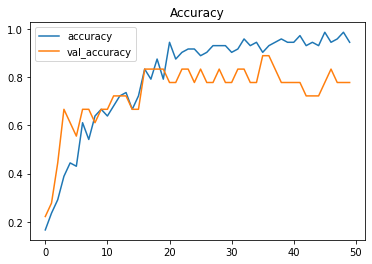

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

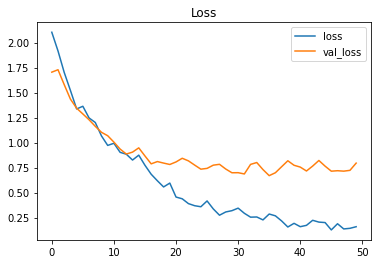

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
prediction = transfer_model.predict(validation_generator)

In [ ]:
output = np.argmax(prediction, axis=1)
labels = validation_generator.class_indices
print(labels)
print(type(labels))
pred_labels = dict((v,k) for k,v in labels.items())
print(pred_labels)
print(type(pred_labels))

{'acai': 0, 'cupuacu': 1, 'graviola': 2, 'guarana': 3, 'pupunha': 4, 'tucuma': 5}
<class 'dict'>
{0: 'acai', 1: 'cupuacu', 2: 'graviola', 3: 'guarana', 4: 'pupunha', 5: 'tucuma'}
<class 'dict'>


In [ ]:
labeled_pred = []
for i in range(0, len(output)):
    labeled_pred.append(pred_labels[output[i]])

In [ ]:
labeled_test = []
for i in range(0, len(output)):
    labeled_test.append(pred_labels[validation_generator.classes[i]])

Mostramos la reporte de clasificación para ver como se desempeño en cada caso para cada clase.

In [ ]:
print(classification_report(labeled_test, labeled_pred))
cf_matrix=confusion_matrix(labeled_test, labeled_pred)

              precision    recall  f1-score   support

        acai       1.00      0.67      0.80         3
     cupuacu       0.60      1.00      0.75         3
    graviola       1.00      1.00      1.00         3
     guarana       1.00      0.67      0.80         3
     pupunha       1.00      0.33      0.50         3
      tucuma       0.60      1.00      0.75         3

    accuracy                           0.78        18
   macro avg       0.87      0.78      0.77        18
weighted avg       0.87      0.78      0.77        18



Ahora veremos la matriz de confusión

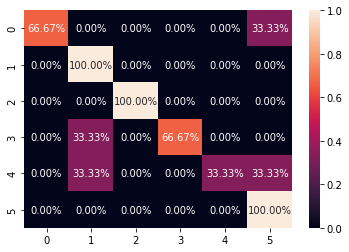

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix,axis=1), annot=True, fmt='.2%')

### Inception Versión 3

Ahora probaremos con un modelo Inception Versión 3, y al igual que para el VG16, para evitar que tome mucho tiempo el procesamiento de este modelo, no descongelaremos ninguna de las capas

In [ ]:
from keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

for layer in inception_model.layers:
  layer.trainable = False
for i, layer in enumerate(inception_model.layers):
  print(i, layer.name, layer.trainable)

87924736/87910968 [==============================] - 1s 0us/step
0 input_5 False
1 conv2d_94 False
2 batch_normalization_94 False
3 activation_94 False
4 conv2d_95 False
5 batch_normalization_95 False
6 activation_95 False
7 conv2d_96 False
8 batch_normalization_96 False
9 activation_96 False
10 max_pooling2d_4 False
11 conv2d_97 False
12 batch_normalization_97 False
13 activation_97 False
14 conv2d_98 False
15 batch_normalization_98 False
16 activation_98 False
17 max_pooling2d_5 False
18 conv2d_102 False
19 batch_normalization_102 False
20 activation_102 False
21 conv2d_100 False
22 conv2d_103 False
23 batch_normalization_100 False
24 batch_normalization_103 False
25 activation_100 False
26 activation_103 False
27 average_pooling2d_9 False
28 conv2d_99 False
29 conv2d_101 False
30 conv2d_104 False
31 conv2d_105 False
32 batch_normalization_99 False
33 batch_normalization_101 False
34 batch_normalization_104 False
35 batch_normalization_105 False
36 activation_99 False
37 activation_1

In [ ]:
x = inception_model.output
x = Flatten()(x) # La salida del modelo VGG tenemos que llevarla a una capa de aplanamiento para poder entrar en la parte de fully connection
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Agregamos una capa de dropout a manera de evitar el sobreajuste
x = Dense(256, activation='relu')(x)
x = Dense(6, activation='softmax')(x) # Como es una tarea de multiclasificación entonces necesitamos especificar una función de activación softmax con 6 neuronas, una por cada clase
transfer_model2 = Model(inputs=inception_model.input, outputs=x)

Definimos la función de pérdida como Entropía cruzada categórica.
Para el optimizador utilizamos un ADAM que partirá de una learning rate muy pequeña.

In [ ]:
learning_rate= 5e-5
transfer_model2.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = transfer_model2.fit(train_generator, batch_size = 1, epochs=50, validation_data=validation_generator)

Epoch 1/50
5/5 [==============================] - 17s 3s/step - loss: 2.5601 - accuracy: 0.1944 - val_loss: 1.8897 - val_accuracy: 0.3333
Epoch 2/50
5/5 [==============================] - 14s 3s/step - loss: 1.9990 - accuracy: 0.3472 - val_loss: 1.3646 - val_accuracy: 0.6111
Epoch 3/50
5/5 [==============================] - 11s 2s/step - loss: 1.3250 - accuracy: 0.5694 - val_loss: 0.9135 - val_accuracy: 0.6667
Epoch 4/50
5/5 [==============================] - 11s 2s/step - loss: 1.0024 - accuracy: 0.6250 - val_loss: 0.7496 - val_accuracy: 0.6667
Epoch 5/50
5/5 [==============================] - 11s 2s/step - loss: 1.2460 - accuracy: 0.5833 - val_loss: 0.4604 - val_accuracy: 0.8333
Epoch 6/50
5/5 [==============================] - 11s 2s/step - loss: 0.9714 - accuracy: 0.6250 - val_loss: 0.4150 - val_accuracy: 0.8889
Epoch 7/50
5/5 [==============================] - 11s 2s/step - loss: 0.7513 - accuracy: 0.7639 - val_loss: 0.3446 - val_accuracy: 0.8889
Epoch 8/50
5/5 [==================

Graficamos el comportamiento del perfomance que tuvo durante cada época para tanto en la función en la pérdida como en la de asertividad

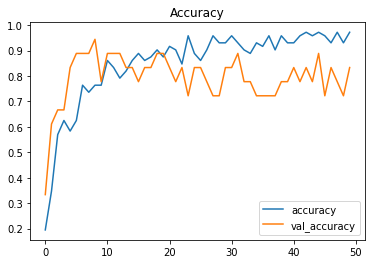

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

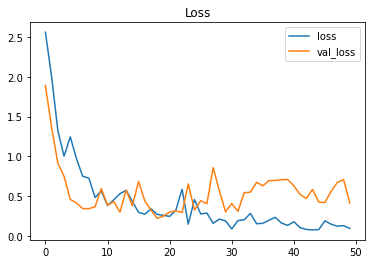

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
prediction = transfer_model2.predict(validation_generator)

In [ ]:
output = np.argmax(prediction, axis=1)
labels = validation_generator.class_indices
print(labels)
print(type(labels))
pred_labels = dict((v,k) for k,v in labels.items())
print(pred_labels)
print(type(pred_labels))

{'acai': 0, 'cupuacu': 1, 'graviola': 2, 'guarana': 3, 'pupunha': 4, 'tucuma': 5}
<class 'dict'>
{0: 'acai', 1: 'cupuacu', 2: 'graviola', 3: 'guarana', 4: 'pupunha', 5: 'tucuma'}
<class 'dict'>


In [ ]:
labeled_pred = []
for i in range(0, len(output)):
    labeled_pred.append(pred_labels[output[i]])

In [ ]:
labeled_test = []
for i in range(0, len(output)):
    labeled_test.append(pred_labels[validation_generator.classes[i]])

Mostramos la reporte de clasificación para ver como se desempeño en cada caso para cada clase.

In [ ]:
print(classification_report(labeled_test, labeled_pred))
cf_matrix=confusion_matrix(labeled_test, labeled_pred)

              precision    recall  f1-score   support

        acai       1.00      0.67      0.80         3
     cupuacu       1.00      1.00      1.00         3
    graviola       1.00      1.00      1.00         3
     guarana       1.00      1.00      1.00         3
     pupunha       1.00      0.33      0.50         3
      tucuma       0.50      1.00      0.67         3

    accuracy                           0.83        18
   macro avg       0.92      0.83      0.83        18
weighted avg       0.92      0.83      0.83        18



Ahora veremos la matriz de confusión

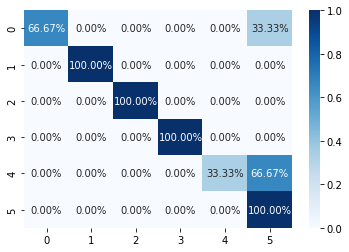

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix,axis=1), annot=True, fmt='.2%', cmap='Blues')

**Conclusiones:**

Como podemos ver en las gráficas de asertividad y pérdidas de ambos modelos, ambos tienen un buen desempeño pero hay un punto en donde el conjunto de prueba en donde se estabiliza y se genera un espacio importante contra el conjunto de entrenamiento, sin embargo, esto es mucho menos notorio cuando observamos el modelo InceptionV3, por otro lado al observar la matriz de confusión de ambos modelos de nuevo obtenemos como ganador el modelo inception v3, ya que solo tiene dificultades en 2 clases mientras que el vgg16 tiene problemas con 4 clases.